# 03. Dataset Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Dataset

In [2]:
df = pd.read_csv("..\data\processed\modeldataset.csv")
df.head()

,instance,VariablesVari.,BinariesBina.,IntegersInte.,ContinuousCont.,ConstraintsCons.,Nonz.Nonz.,param_id,runtime,gap,status,objval
0,30n20b8,18380,18318,62,0,576,109706,0,2.487,0.0,2,302.0
1,30n20b8,18380,18318,62,0,576,109706,1,90.003,0.0,9,302.0
2,30n20b8,18380,18318,62,0,576,109706,2,90.005,0.0,9,302.0
3,30n20b8,18380,18318,62,0,576,109706,3,4.297,0.0,2,302.0
4,30n20b8,18380,18318,62,0,576,109706,4,69.428,0.0,2,302.0


## Overview Analysis

- parameter sets counts --> just to check the completeness of the dataset
- status counts --> to check if most of them are 2 (Status identifier:  2=OPTIMAL，3=INFEASIBLE，9=TIME_LIMIT)
- solve results categories --> to distinguish between optimal, quasi optimal, not converged and not feasible cases

#### Parameter sets counts

<Axes: title={'center': 'Parameter ID Distribution'}, xlabel='param_id', ylabel='Count'>

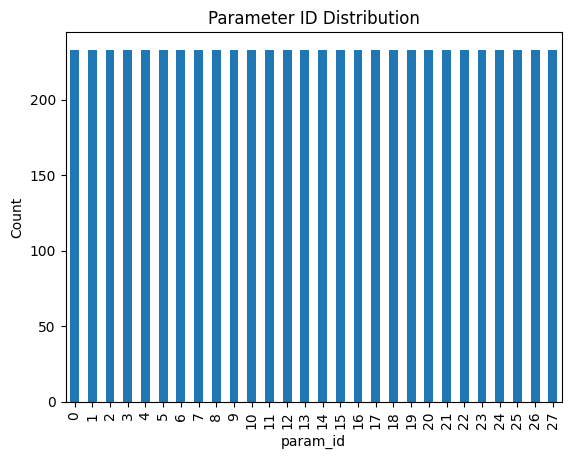

In [3]:
param_counts = df["param_id"].value_counts().sort_index()
param_counts.plot(kind="bar", title="Parameter ID Distribution", xlabel="param_id", ylabel="Count")

#### Status counts

<Axes: title={'center': 'Solver Status Distribution'}, xlabel='status', ylabel='Count'>

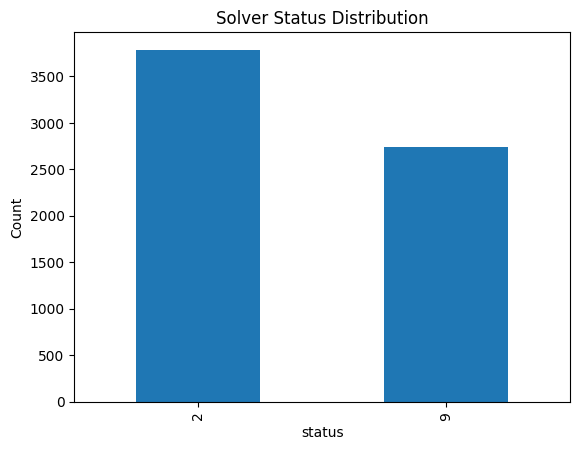

In [6]:
status_counts = df["status"].value_counts().sort_index()
status_counts.plot(kind="bar", title="Solver Status Distribution", xlabel="status", ylabel="Count")

To distinguish the following cases:
- status==2: optimal sol
- status==9, runtime == time_limit, gap < gap_threshold: found a best sol but not able to prove its optimality due to time limit
- status==9, runtime == 3600, gap> gap_threshold: found a feasible sol but it's not best, can be seen as not find a possible best sol in time limit
- status==9, runtime ==3600, gap = 1.0: didn't find a feasible sol during the time limit

Now I want to count how often each cases appears

In [7]:
def classify_result(row, gap_threshold=0.05):
    status = row["status"]
    gap = row["gap"]
    runtime = row["runtime"]
    
    if status == 2:
        return "Optimal"
    elif status == 9 and gap <= gap_threshold:
        return "Quasi-optimal"
    elif status == 9 and gap != 1.0 and runtime==3600:
        return "Not converged"
    elif status == 9 and gap == 1.0 and runtime==3600:
        return "No feasible"
    else:
        return "Other"

<Axes: title={'center': 'Solve Result Categories'}, xlabel='Category', ylabel='Count'>

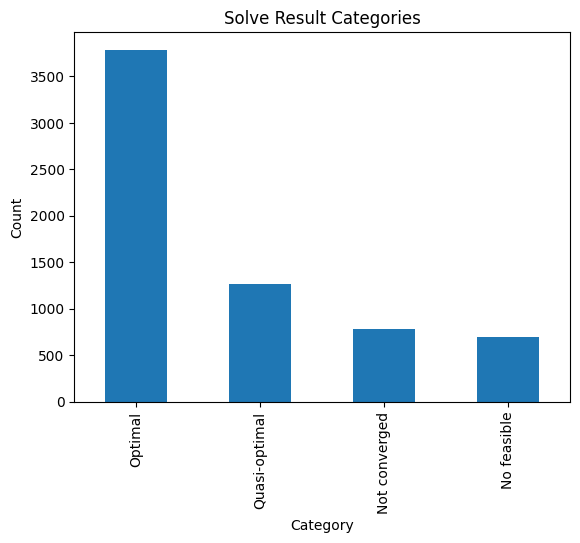

In [8]:
df["solve_category"] = df.apply(classify_result, axis=1)
category_counts = df["solve_category"].value_counts()
category_counts.plot(kind="bar", title="Solve Result Categories", xlabel="Category", ylabel="Count")

## Per Parameter Set Analysis

- solve results per param set
- Best param set frequency

#### Each param set distinguish the 4 cases

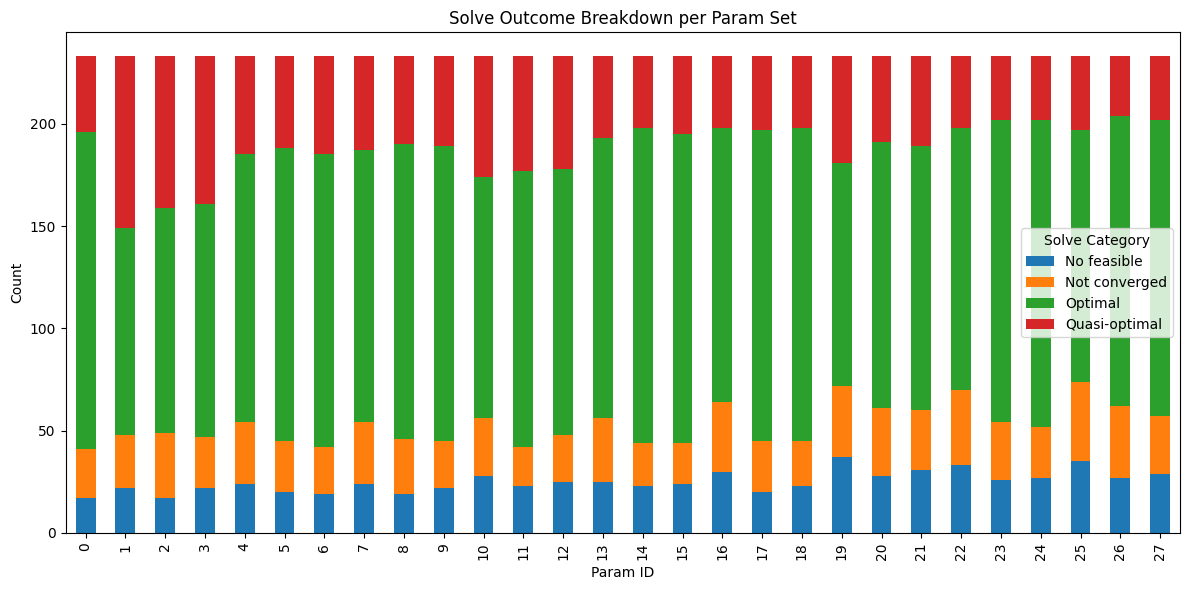

In [9]:
category_counts = df.groupby(["param_id", "solve_category"]).size().unstack(fill_value=0)
category_counts.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Solve Outcome Breakdown per Param Set")
plt.xlabel("Param ID")
plt.ylabel("Count")
plt.legend(title="Solve Category")
plt.tight_layout()
plt.show()

In [11]:
summary_stats = []

for category in category_counts.columns:
    values = category_counts[category]
    max_param = values.idxmax()
    max_val = values.max()
    min_param = values.idxmin()
    min_val = values.min()
    mean_val = values.mean()

    summary_stats.append({
        "Category": category,
        "Max Param": max_param,
        "Max Count": round(max_val, 3),
        "Min Param": min_param,
        "Min Count": round(min_val, 3),
        "Mean Count": round(mean_val, 3)
    })

summary_df = pd.DataFrame(summary_stats)
display(summary_df)

,Category,Max Param,Max Count,Min Param,Min Count,Mean Count
0,No feasible,19,37,0,17,25.000
1,Not converged,25,39,11,19,27.750
2,Optimal,0,155,1,101,135.214
3,Quasi-optimal,1,84,26,29,45.036


#### Best param set frequency

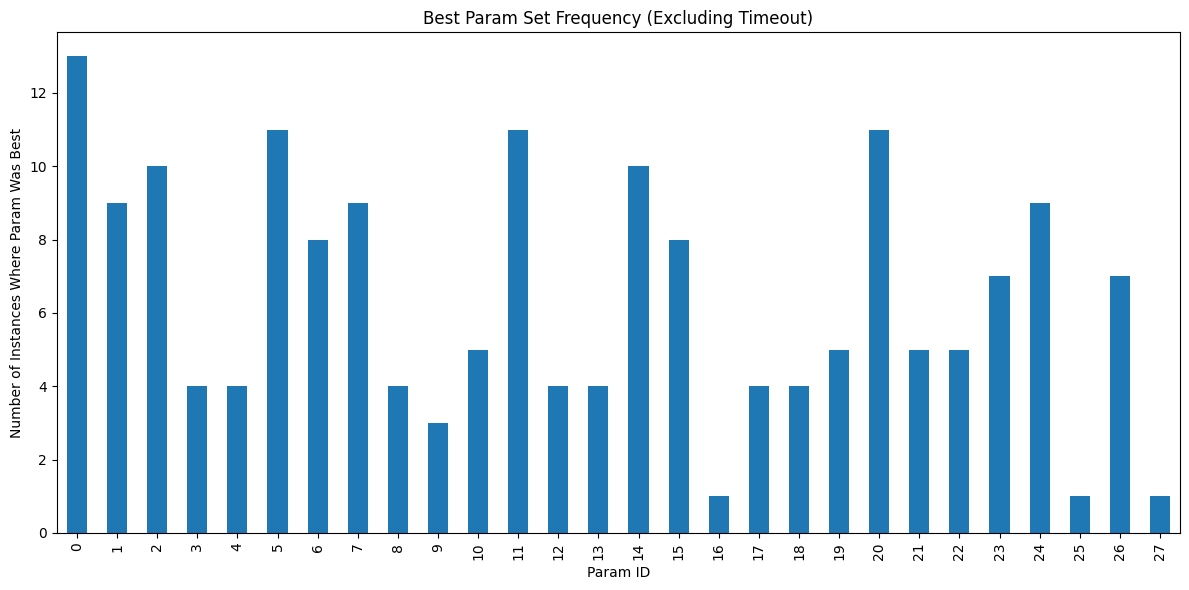

In [12]:
df_valid = df[df["status"] != 9]
best_rows = df_valid.loc[df_valid.groupby("instance")["runtime"].idxmin()]
best_param_counts = best_rows["param_id"].value_counts().sort_index()

best_param_counts.plot(kind="bar", figsize=(12,6))
plt.title("Best Param Set Frequency (Excluding Timeout)")
plt.xlabel("Param ID")
plt.ylabel("Number of Instances Where Param Was Best")
plt.tight_layout()
plt.show()

And also we check their average runtime as the best param set

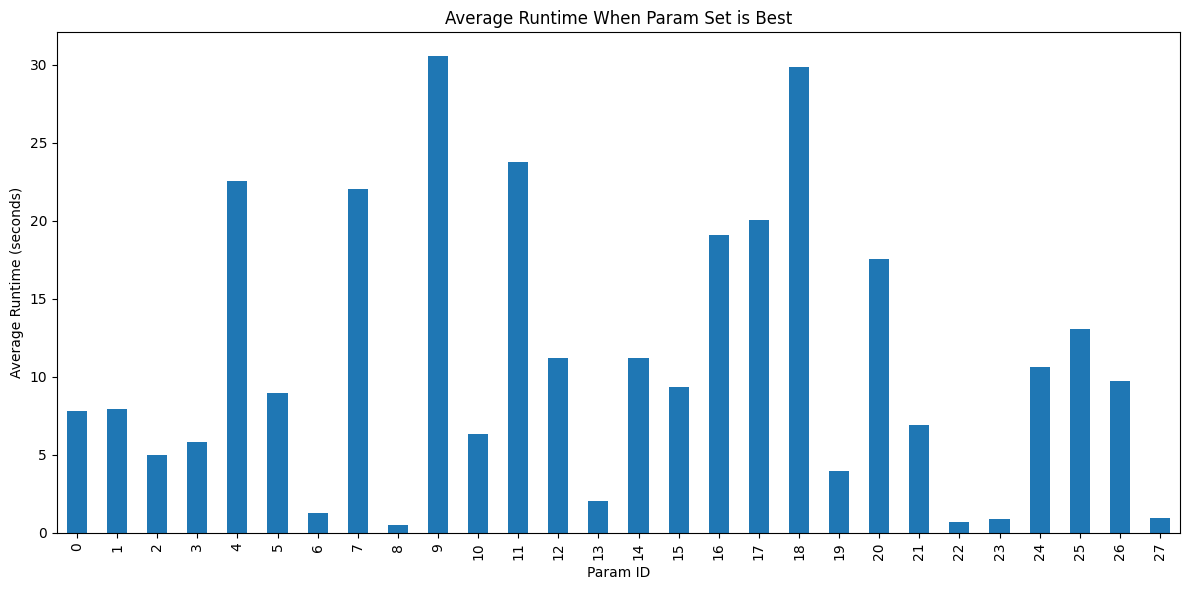

In [15]:
avg_runtimes = best_rows.groupby("param_id")["runtime"].mean()

avg_runtimes.plot(kind="bar", figsize=(12,6))
plt.title("Average Runtime When Param Set is Best")
plt.ylabel("Average Runtime (seconds)")
plt.xlabel("Param ID")
plt.tight_layout()
plt.show()

Combine these two analysis to find which seems to be the "best" param set (more often to be the best param set and with faster runtime) ,use the scatter plot

In [16]:
best_summary = pd.DataFrame({
    "Best_Count": best_param_counts,
    "Avg_Best_Runtime": avg_runtimes
}).reset_index().rename(columns={"param_id": "Param_ID"})

C:\Users\WEI\AppData\Local\Temp\ipykernel_28936\239307904.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


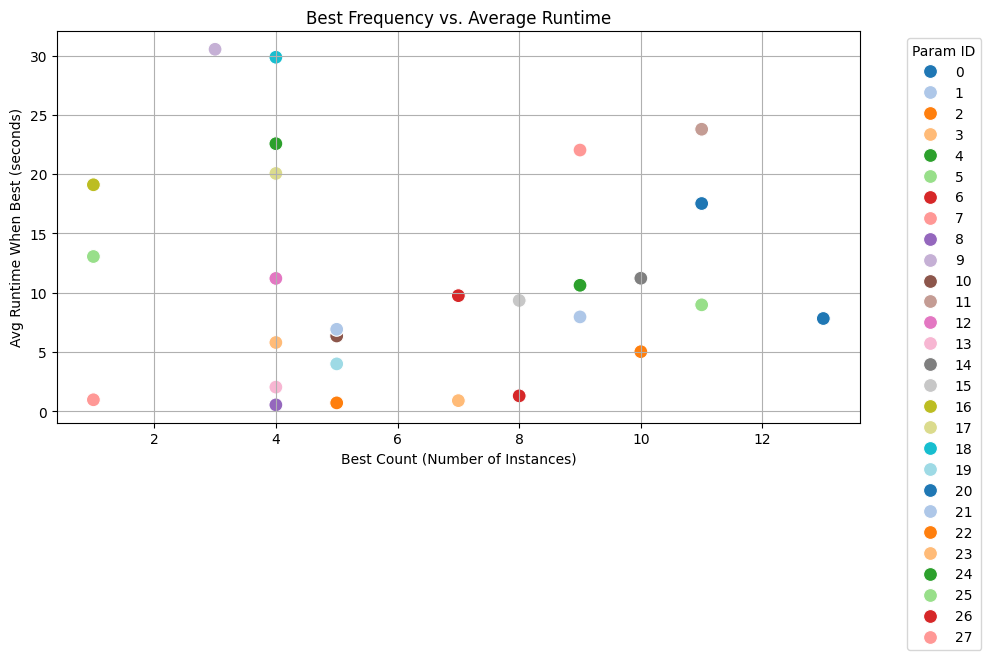

In [20]:
plt.figure(figsize=(10,6), constrained_layout=True)
sns.scatterplot(data=best_summary, x="Best_Count", y="Avg_Best_Runtime", hue="Param_ID", palette="tab20", s=100)

plt.title("Best Frequency vs. Average Runtime")
plt.xlabel("Best Count (Number of Instances)")
plt.ylabel("Avg Runtime When Best (seconds)")
plt.legend(title="Param ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()